##  Data Preparation and preprocessing

In [23]:
!pip install patchify

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import cv2
from PIL import Image
import zipfile
import os
from patchify import patchify
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
extract_zip= zipfile.ZipFile('/content/drive/MyDrive/Projects/Deep_learning_satellite_imagery/archive.zip')
extract_zip.extractall()

In [7]:
image_patch_size= 256

(2, 2, 1, 256, 256, 3)
(2, 2, 1, 256, 256, 3)


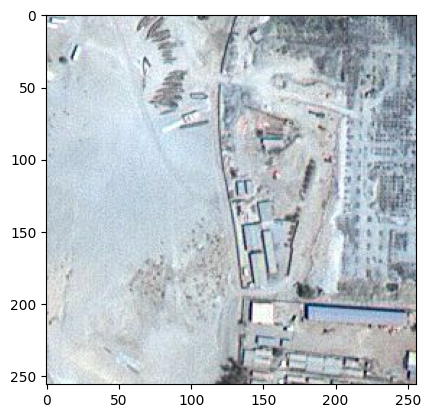

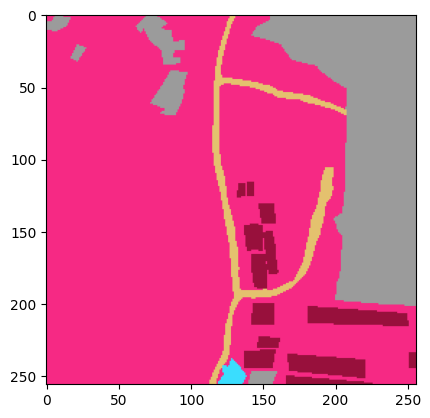

In [8]:
### code to test the patchify for patches
path_image= '/content/Semantic segmentation dataset/Tile 3/images/image_part_001.jpg'
path_mask= '/content/Semantic segmentation dataset/Tile 3/masks/image_part_001.png'
image= cv2.imread(path_image)
mask= cv2.imread(path_mask)
#print(image.shape)
patchs_image= patchify(image,(image_patch_size,image_patch_size,3),step=image_patch_size)
patchs_mask= patchify(mask,(image_patch_size,image_patch_size,3),step=image_patch_size)
print(patchs_image.shape)
print(patchs_mask.shape)

plt.imshow(patchs_image[0,0,0,:,:,:])
plt.show()
plt.imshow(patchs_mask[0,0,0,:,:,:])
plt.show()

In [9]:
water_color="#E2A929"
water_color= water_color.lstrip('#')
water_RGB= [int(water_color[i:i+2], 16)  for i in range(0,len(water_color),2)]

land_color="#8429F6"
land_color= land_color.lstrip('#')
land_RGB= [int(land_color[i:i+2], 16)  for i in range(0,len(land_color),2)]

road_color="#6EC1E4"
road_color= road_color.lstrip('#')
road_RGB= [int(road_color[i:i+2], 16)  for i in range(0,len(road_color),2)]

building_color= "#3C1098"
building_color= building_color.lstrip('#')
building_RGB= [int(building_color[i:i+2], 16)  for i in range(0,len(building_color),2)]

vegetation_color= "#FEDD3A"
vegetation_color= vegetation_color.lstrip('#')
vegetation_RGB= [int(vegetation_color[i:i+2], 16)  for i in range(0,len(vegetation_color),2)]

unlabeled_color= "#9B9B9B"
unlabeled_color= unlabeled_color.lstrip('#')
unlabeled_RGB= [int(unlabeled_color[i:i+2], 16)  for i in range(0,len(unlabeled_color),2)]

In [10]:
print(water_RGB, land_RGB, road_RGB, building_RGB, vegetation_RGB, unlabeled_RGB)


[226, 169, 41] [132, 41, 246] [110, 193, 228] [60, 16, 152] [254, 221, 58] [155, 155, 155]


In [11]:
dir_path= ('/content/Semantic segmentation dataset')
images_dataset=[]
masks_dataset=[]
labels_dataset=[]
for (root,dirs,files) in os.walk(dir_path):
  #print(root)
  if (os.path.split(root)[-1]== 'images'):
    #print(root)
    #images_path_list=[os.path.join(root,i) for i in os.listdir(root)]
    for num in range(1,10):
      path= os.path.join(root,'image_part_00{}.jpg'.format(num))
      image= cv2.imread(path,1)
      #print(image.shape)
      patchs_image= patchify(image,(image_patch_size,image_patch_size,3),step=image_patch_size)
      for i in range(patchs_image.shape[0]):
        for j in range(patchs_image.shape[1]):
          #image_patch=patchs_image[i,j,0,:,:,:]/255.0
          images_dataset.append(patchs_image[i,j,0,:,:,:]/255.0)
  if (os.path.split(root)[-1]== 'masks'):
    #print(root)
    #masks_path_list=[os.path.join(root,i) for i in os.listdir(root)]
    for num in range(1,10):
      path= os.path.join(root,'image_part_00{}.png'.format(num))
      mask= cv2.imread(path,1)
      mask= cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
      #print(image.shape)
      patchs_mask= patchify(mask,(image_patch_size,image_patch_size,3),step=image_patch_size)
      for i in range(patchs_mask.shape[0]):
        for j in range(patchs_mask.shape[1]):
          #image_patch=patchs_mask[i,j,0,:,:,:]
          masks_dataset.append(patchs_mask[i,j,0,:,:,:])

In [12]:
images_dataset= np.asarray(images_dataset)
masks_dataset= np.asarray(masks_dataset)
print(images_dataset.shape)
print(masks_dataset.shape)

(1305, 256, 256, 3)
(1305, 256, 256, 3)


In [13]:
#np.arange(images_dataset.shape[0])

In [14]:
## Extracting only 700 images out of 1305 from the dataset due to RAM limitations

idx= np.random.choice(np.arange(images_dataset.shape[0]), 700, replace= False)
images_dataset= images_dataset[idx]
masks_dataset= masks_dataset[idx]

In [15]:
print(images_dataset.shape)
print(masks_dataset.shape)

(700, 256, 256, 3)
(700, 256, 256, 3)


In [16]:
def rgb_to_label(image):
  label= np.zeros((image.shape[0], image.shape[1],3))
  label[np.all(image == water_RGB, axis=-1)]=0
  label[np.all(image == land_RGB, axis=-1)]= 1
  label[np.all(image == road_RGB, axis=-1)]= 2
  label[np.all(image == building_RGB, axis=-1)]= 3
  label[np.all(image == vegetation_RGB, axis=-1)]= 4
  label[np.all(image == unlabeled_RGB,axis=-1)]= 5
  #print(np.unique(label))
  return(label[:,:,0])

In [17]:
for i in range(masks_dataset.shape[0]):
  #image = masks_dataset[i]
  label= rgb_to_label(masks_dataset[i])
  labels_dataset.append(label)



In [18]:
labels_dataset= np.asarray(labels_dataset)

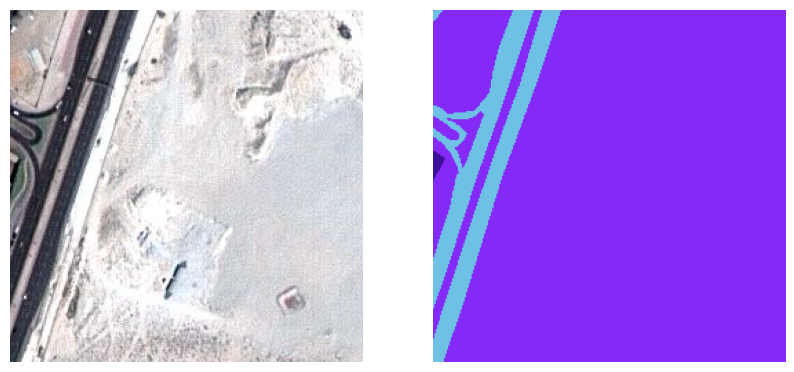

array([1., 2., 3.])

In [19]:
rand_num= np.random.randint(0,masks_dataset.shape[0])
plt.figure(figsize=(10,14))
plt.subplot(1,2,1)
plt.imshow(images_dataset[rand_num,:,:,:])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(masks_dataset[rand_num,:,:,:])
plt.axis('off')
plt.show()
np.unique(labels_dataset[rand_num,:,:])

In [20]:
labels_dataset.shape

(700, 256, 256)

In [21]:
labels_dataset= to_categorical(labels_dataset,num_classes= 6)
labels_dataset.shape


(700, 256, 256, 6)

In [22]:
#labels_dataset[0]

In [23]:
images_dataset[0]

array([[[0.49411765, 0.51764706, 0.44313725],
        [0.47058824, 0.48627451, 0.41176471],
        [0.47843137, 0.48627451, 0.41176471],
        ...,
        [0.3372549 , 0.36470588, 0.30588235],
        [0.32941176, 0.35686275, 0.29803922],
        [0.36862745, 0.4       , 0.33333333]],

       [[0.49019608, 0.51764706, 0.43529412],
        [0.4745098 , 0.49019608, 0.41568627],
        [0.47058824, 0.47843137, 0.40392157],
        ...,
        [0.33333333, 0.36078431, 0.30196078],
        [0.32156863, 0.34901961, 0.29019608],
        [0.36078431, 0.38823529, 0.32941176]],

       [[0.4745098 , 0.50980392, 0.42745098],
        [0.4745098 , 0.50196078, 0.41960784],
        [0.46666667, 0.48627451, 0.40392157],
        ...,
        [0.32156863, 0.34901961, 0.29019608],
        [0.31372549, 0.34117647, 0.28235294],
        [0.34509804, 0.37254902, 0.31372549]],

       ...,

       [[0.29803922, 0.25098039, 0.23529412],
        [0.30588235, 0.25098039, 0.22745098],
        [0.32941176, 0

In [24]:
X_train,X_test, y_train, y_test= train_test_split(images_dataset, labels_dataset, train_size=0.8, random_state=100)

In [25]:
print(X_train.shape)
print(y_train.shape)

(560, 256, 256, 3)
(560, 256, 256, 6)


### Model Building- UNET

In [27]:
from keras.models import Model, load_model
from keras.layers import Conv2D, Conv2DTranspose, Dropout, MaxPool2D, BatchNormalization,Input,Dense, concatenate, Lambda
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from numpy.testing import assert_allclose

In [28]:
input_height= X_train.shape[1]
input_weight= X_train.shape[2]
input_channels= 3
#batch_size= 64

In [29]:
def unet_model(input_height= 128, input_weight=128, input_channels= 1, num_classes= 5) :
  source_input = Input((input_height, input_weight, input_channels))
  c1= Conv2D(16,(3,3),padding='same',activation='relu',kernel_initializer= 'he_normal')(source_input)
  c1= Dropout(0.2)(c1)
  c1= Conv2D(16,(3,3),padding='same',activation='relu',kernel_initializer= 'he_normal')(c1)
  p1= MaxPool2D((2,2))(c1)

  c2= Conv2D(32,(3,3),padding='same',activation='relu',kernel_initializer= 'he_normal')(p1)
  c2= Dropout(0.2)(c2)
  c2= Conv2D(32,(3,3),padding='same',activation='relu',kernel_initializer= 'he_normal')(c2)
  p2= MaxPool2D((2,2))(c2)

  c3= Conv2D(64,(3,3),padding='same',activation='relu',kernel_initializer= 'he_normal')(p2)
  c3= Dropout(0.2)(c3)
  c3= Conv2D(64,(3,3),padding='same',activation='relu',kernel_initializer= 'he_normal')(c3)
  p3= MaxPool2D((2,2))(c3)

  c4= Conv2D(128,(3,3),padding='same',activation='relu',kernel_initializer= 'he_normal')(p3)
  c4= Dropout(0.2)(c4)
  c4= Conv2D(128,(3,3),padding='same',activation='relu',kernel_initializer= 'he_normal')(c4)
  p4= MaxPool2D((2,2))(c4)

  m5= Conv2D(256,(3,3),padding='same',activation='relu',kernel_initializer= 'he_normal')(p4)
  m5= Dropout(0.2)(m5)
  m5= Conv2D(256,(3,3),padding='same',activation='relu',kernel_initializer= 'he_normal')(m5)

  u6= Conv2DTranspose(128,(3,3),strides=(2,2),padding='same')(m5)
  u6= concatenate([u6,c4])
  u6= Conv2D(128,(3,3),padding='same',activation='relu',kernel_initializer= 'he_normal')(u6)
  u6= Dropout(0.2)(u6)
  u6= Conv2D(128,(3,3),padding='same',activation='relu',kernel_initializer= 'he_normal')(u6)


  u7= Conv2DTranspose(64,(3,3),strides=(2,2),padding='same')(u6)
  u7= concatenate([u7,c3])
  u7= Conv2D(64,(3,3),padding='same',activation='relu',kernel_initializer= 'he_normal')(u7)
  u7= Dropout(0.2)(u7)
  u7= Conv2D(64,(3,3),padding='same',activation='relu',kernel_initializer= 'he_normal')(u7)

  u8= Conv2DTranspose(32,(3,3),strides=(2,2),padding='same')(u7)
  u8= concatenate([u8,c2])
  u8= Conv2D(32,(3,3),padding='same',activation='relu',kernel_initializer= 'he_normal')(u8)
  u8= Dropout(0.2)(u8)
  u8= Conv2D(32,(3,3),padding='same',activation='relu',kernel_initializer= 'he_normal')(u8)

  u9= Conv2DTranspose(16,(3,3),strides=(2,2),padding='same')(u8)
  u9= concatenate([u9,c1])
  u9= Conv2D(16,(3,3),padding='same',activation='relu',kernel_initializer= 'he_normal')(u9)
  u9= Dropout(0.2)(u9)
  u9= Conv2D(16,(3,3),padding='same',activation='relu',kernel_initializer= 'he_normal')(u9)

  output_layer = Conv2D(num_classes, (1,1), padding="same", activation="softmax")(u9)

  model= Model(inputs=[source_input], outputs= [output_layer])

  return(model)

In [30]:
model= unet_model(input_height, input_weight, input_channels= 3, num_classes= 6)

In [31]:
def IoU(true_labels, predicted_labels):
  true_y = K.flatten(true_labels)
  predicted_y= K.flatten(predicted_labels)
  intersection= K.sum(true_y * predicted_y)
  IoU_value= (intersection+1.0)/ (K.sum(true_y) + K.sum(predicted_y)- intersection +1.0)
  return IoU_value

In [32]:
!pip install -U segmentation-models

In [33]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [34]:
import segmentation_models as sm


Segmentation Models: using `tf.keras` framework.


In [35]:
equal_class_weights= [0.166 , 0.166, 0.166, 0.166, 0.166 , 0.166]
dice_loss= sm.losses.DiceLoss(class_weights= equal_class_weights)
focal_loss= sm.losses.CategoricalFocalLoss()

total_losses= dice_loss + (1 * focal_loss)

In [36]:
metrics=['accuracy', IoU]
optimizer= 'Adam'
loss= total_losses

In [37]:
model.compile(optimizer= optimizer,  loss = loss, metrics = metrics)

In [38]:
### Run for the first time while training

#history= model.fit(X_train, y_train, batch_size=16, verbose=1, epochs=5 , validation_data= (X_test, y_test), shuffle= False, callbacks= callbacks_list)
#history= model.fit(X_train, y_train, batch_size=16, verbose=1, epochs=5 , validation_data= (X_test, y_test), shuffle= False)


### Saving the model

In [39]:
from keras.models import save_model

In [49]:
### saving the model and weights

model_json = network_loaded.to_json()
with open('/content/drive/MyDrive/Projects/Deep_learning_satellite_imagery/model1.json','w') as json_file:
  json_file.write(model_json)

network_save= save_model(network_loaded, '/content/drive/MyDrive/Projects/Deep_learning_satellite_imagery/model_epoch40.hdf5')

### Loading the model

In [41]:
## opening the model saved

with open('/content/drive/MyDrive/Projects/Deep_learning_satellite_imagery/model1.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Functional", "config": {"name": "model", "trainable": true, "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "dtype": "float32", "filters": 16, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "HeNormal", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "name": "conv2d", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Dropout", "config": {"name": "dropout", "trainable": true, "dtype": "float32", "rate"

In [42]:
## loading the weights

network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('/content/drive/MyDrive/Projects/Deep_learning_satellite_imagery/model_epoch40.hdf5')
network_loaded.compile(optimizer= optimizer,  loss = loss, metrics = metrics)

In [43]:
### training the loaded model

history=network_loaded.fit(X_train, y_train, epochs=15, batch_size=16,verbose=1, validation_data= (X_test, y_test), shuffle= False)

Epoch 1/15
35/35 [==============================] - 29s 297ms/step - loss: 0.9238 - accuracy: 0.8199 - IoU: 0.6268 - val_loss: 0.9293 - val_accuracy: 0.8007 - val_IoU: 0.6201
Epoch 2/15
35/35 [==============================] - 8s 216ms/step - loss: 0.9187 - accuracy: 0.8310 - IoU: 0.6509 - val_loss: 0.9395 - val_accuracy: 0.7725 - val_IoU: 0.5819
Epoch 3/15
35/35 [==============================] - 8s 218ms/step - loss: 0.9169 - accuracy: 0.8367 - IoU: 0.6599 - val_loss: 0.9327 - val_accuracy: 0.7900 - val_IoU: 0.6130
Epoch 4/15
35/35 [==============================] - 8s 217ms/step - loss: 0.9148 - accuracy: 0.8412 - IoU: 0.6693 - val_loss: 0.9303 - val_accuracy: 0.7981 - val_IoU: 0.6231
Epoch 5/15
35/35 [==============================] - 8s 226ms/step - loss: 0.9133 - accuracy: 0.8451 - IoU: 0.6747 - val_loss: 0.9327 - val_accuracy: 0.7907 - val_IoU: 0.6206
Epoch 6/15
35/35 [==============================] - 7s 210ms/step - loss: 0.9126 - accuracy: 0.8473 - IoU: 0.6781 - val_loss: 0.9

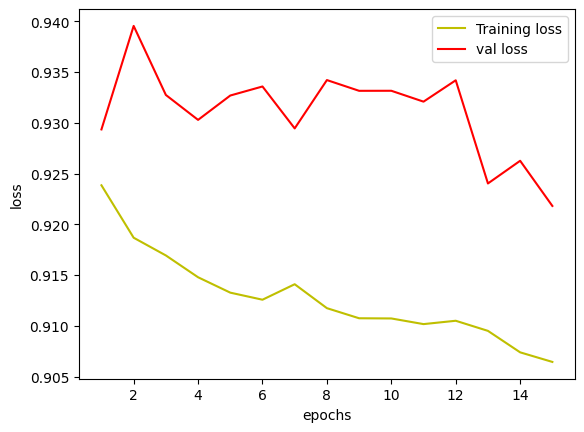

In [44]:
loss= history.history['loss']
val_loss= history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs,loss, 'y', label='Training loss')
plt.plot(epochs,val_loss, 'r', label='val loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [45]:
history.history['IoU']

[0.6267926692962646,
 0.650867223739624,
 0.6598737835884094,
 0.6692618131637573,
 0.6747255325317383,
 0.6780530214309692,
 0.6713258624076843,
 0.6817074418067932,
 0.6862897276878357,
 0.6868948340415955,
 0.690101683139801,
 0.6875789165496826,
 0.6933300495147705,
 0.7021636366844177,
 0.7075257897377014]

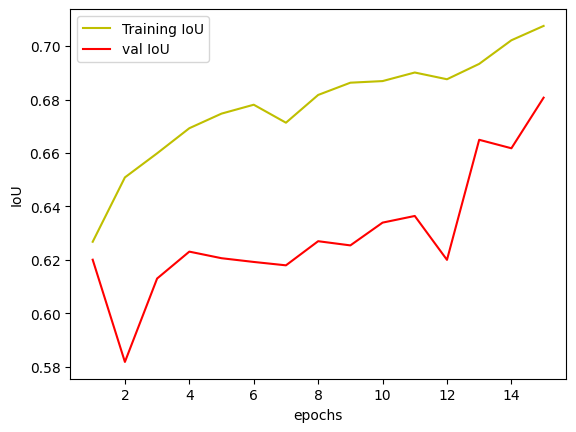

In [46]:
IoU= history.history['IoU']
val_IoU= history.history['val_IoU']
epochs = range(1, len(IoU)+1)
plt.plot(epochs,IoU, 'y', label='Training IoU')
plt.plot(epochs,val_IoU, 'r', label='val IoU')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('IoU')
plt.show()

In [ ]:
y_pred= model.predict(X_test)

In [ ]:
y_pred= np.argmax(y_pred, axis=-1)

In [ ]:
y_pred

### Comparing visually the prediction and the true labels of test data image


In [52]:
num= np.random.randint(0,(X_test.shape[0]))
X= X_test[num]
y= np.argmax(y_test[num], axis=-1)
X= np.expand_dims(X,0)

y_pred= network_loaded.predict(X)

y_pred= np.argmax(y_pred, axis=-1)

1/1 [==============================] - 0s 33ms/step


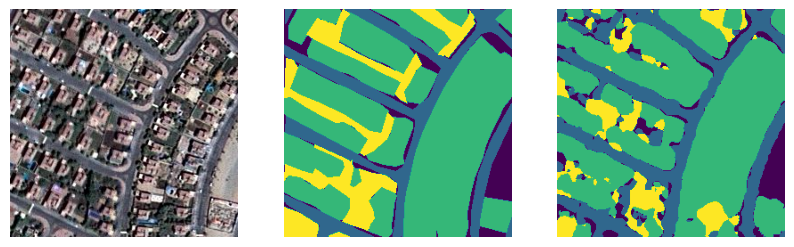

In [53]:
plt.figure(figsize=(10,16))
plt.subplot(1,3,1)
plt.imshow(X[0,:,:,:])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(y)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(y_pred[0,:,:])
plt.axis('off')
plt.show()

### Prediction on custom image

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive


In [27]:
from patchify import patchify

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:
## image taken from google maps
image= cv2.imread('/content/drive/MyDrive/Projects/Deep_learning_satellite_imagery/bel_area.jpg',1)

In [ ]:
## opening the model saved

with open('/content/drive/MyDrive/Projects/Deep_learning_satellite_imagery/model1.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Functional", "config": {"name": "model", "trainable": true, "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "dtype": "float32", "filters": 16, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "HeNormal", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "name": "conv2d", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Dropout", "config": {"name": "dropout", "trainable": true, "dtype": "float32", "rate"

In [ ]:
## loading the weights

network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('/content/drive/MyDrive/Projects/Deep_learning_satellite_imagery/model_epoch40.hdf5')
#network_loaded.compile(optimizer= optimizer,  loss = loss, metrics = metrics)

(4, 256, 256, 3)
1/1 [==============================] - 0s 23ms/step


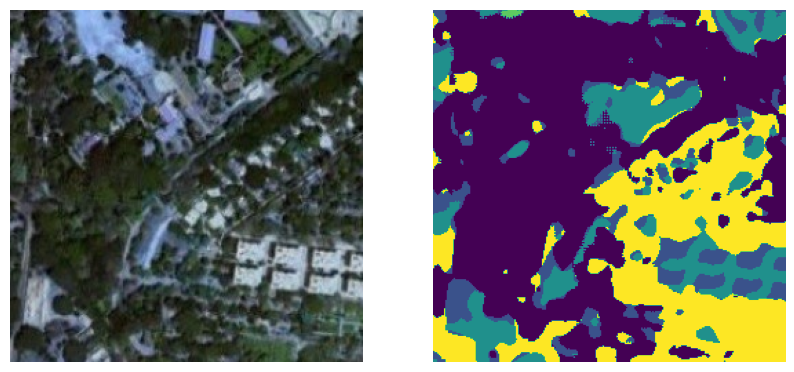

In [65]:
##Cropping the image in patches and predicting

patches= patchify(image,(256,256,3),step=256)
X_test=[]
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    X_test.append(patches[i,j,0,:,:,:])

X_test= np.array(X_test)
print(X_test.shape)
X_test= X_test/255.0

y_pred= network_loaded.predict(X_test)

y_pred= np.argmax(y_pred, axis=-1)

plt.figure(figsize=(10,16))
plt.subplot(1,2,1)
plt.imshow(X_test[0,:,:,:])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(y_pred[0,:,:])
plt.axis('off')
plt.show()

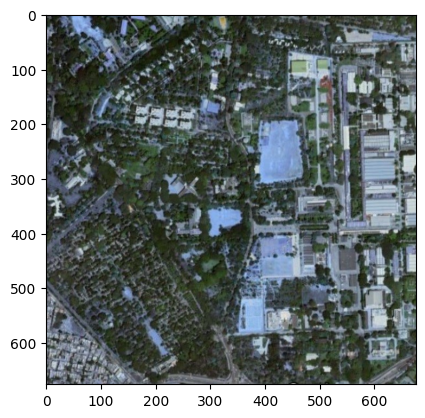

In [55]:
plt.imshow(image)

In [56]:
image = cv2.resize(image, (256,256))

In [57]:
image= np.expand_dims(image, axis=0)

In [58]:
image= image/255.0

In [59]:
image.shape

(1, 256, 256, 3)

In [60]:
y_pred= network_loaded.predict(image)

y_pred= np.argmax(y_pred, axis=-1)

1/1 [==============================] - 0s 34ms/step


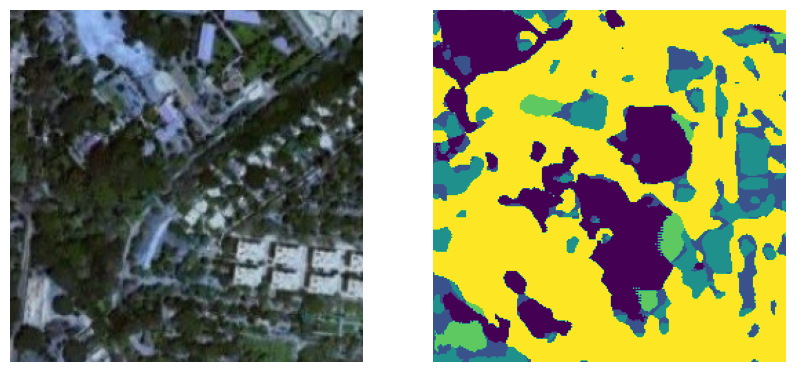

In [61]:
plt.figure(figsize=(10,16))
plt.subplot(1,2,1)
plt.imshow(X_test[0,:,:,:])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(y_pred[0,:,:])
plt.axis('off')
plt.show()

In [62]:
np.unique(y_pred[0,:,:])

array([0, 1, 2, 3, 4])